## Optimal Order Execution Region (spread long-short regions) and Trading Backtest

entering long at: 1.1939397852934053
exiting long with growth: 13.175682070780145%, at: 1.3512494955202194, total_value: 113.17568207078014
entering short at: 1.3512494955202194
exiting short with growth: 0.4080748885696116%, at: 1.3457577958942073, total_value: 113.63752360927839
entering long at: 1.3457577958942073
exiting long with growth: 1.0439287789262142%, at: 1.35980654882019, total_value: 114.82381842189471
entering short at: 1.35980654882019
exiting short with growth: -2.1453320025286424%, at: 1.389618478758038, total_value: 112.36046629876442
entering long at: 1.389618478758038
exiting long with growth: 2.4793820471093433%, at: 1.4240724298436787, total_value: 115.14631152822432
entering short at: 1.4240724298436787
exiting short with growth: 10.347894469981517%, at: 1.2905297710334438, total_value: 127.06153033124113
entering long at: 1.2905297710334438
exiting long with growth: 10.48274245952058%, at: 1.4258126832943203, total_value: 140.38106332099076
entering short at: 1

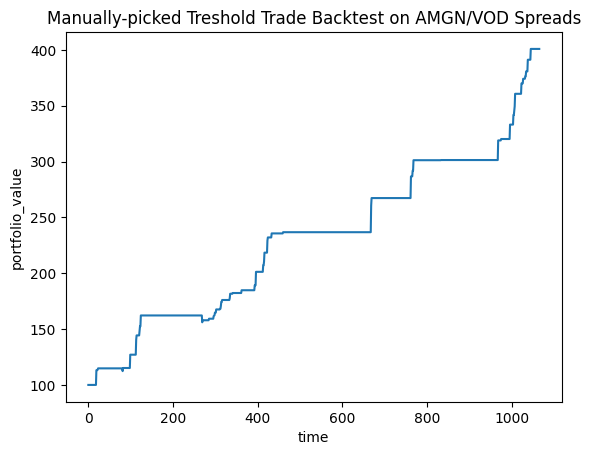

In [44]:
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# We define a backtesting method, that takes
# long-short tresholds and performs a backtest
# this is an oversimplified model that doesn't
# factor in the parameters of the underlying OU
# process and simply trades off arbitrarily
# defined tresholds, this follows an unoptimized
# P/L, which we will later optimize for risk
# appetite or optimality

TRAIN_SET_END = 1450
DATA_BASE = '../data/nasdaq/'
TICKER_BASE = 'AMGN'
TICKER_AUX = 'VOD'

base_path = os.path.join(DATA_BASE, TICKER_BASE + '.pkl')
aux_path = os.path.join(DATA_BASE, TICKER_AUX + '.pkl')

base = pd.read_pickle(base_path)
aux = pd.read_pickle(aux_path)
spreads = base - aux

def process_mean(xt):
    # perform OLS fitting to X_{t} = \beta Y_{t} + \alpha
    x = list(range(len(xt)))
    y = xt[0]

    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    res = model.fit()

    slope = res.params['x1']
    intercept = res.params['const']

    return slope, intercept


def backtest(treshold_down: float, treshold_up: float):
    train_set_spreads = spreads[0:TRAIN_SET_END]
    slope, intercept = process_mean(train_set_spreads)

    test_set_spreads = spreads[TRAIN_SET_END:]
    test_set_len = len(test_set_spreads)


    # perform backtest trading off tresholds
    total_value = 100
    portfolio_values = []

    entered_long = False
    long_entrance_price = 0

    entered_short = False
    short_entrance_price = 0

    enters_long = []
    enters_short = []

    for i in range(test_set_len):
        value = test_set_spreads.iloc[i, 0]

        real_time = TRAIN_SET_END + i
        pred_value = intercept + (slope * real_time)

        if pred_value + treshold_up < value:
            # End long position on spread
            if entered_long:
                entered_long = False
                growth = (value - long_entrance_price) / long_entrance_price
                total_value *= 1 + growth
                long_entrance_price = 0

                print(f'exiting long with growth: {growth * 100}%, at: {value}, total_value: {total_value}')

            # short spread
            if not entered_short:
                entered_short = True
                short_entrance_price = value

                enters_short.append(i)
                print(f'entering short at: {value}')

        elif pred_value + treshold_down > value:
            # End short position on spread
            if entered_short:
                entered_short = False
                growth = (short_entrance_price - value) / value
                total_value *= 1 + growth
                short_entrance_price = 0

                print(f'exiting short with growth: {growth * 100}%, at: {value}, total_value: {total_value}')

            # long-spread
            if not entered_long:
                entered_long = True
                long_entrance_price = value

                enters_long.append(i)
                print(f'entering long at: {value}')

        portfolio_values.append(total_value)

    print(f'total startegy value: {total_value}')
    return portfolio_values, enters_long, enters_short, slope, intercept


TRADE_DOWN = 0.1
TRADE_UP = 0.1

portfolio, long_entrances, short_entrances, total_slope, total_intercept = backtest(TRADE_DOWN, TRADE_UP)
portfolio_df = pd.DataFrame({
    'time': range(len(portfolio)),
    'portfolio_value': portfolio
})

plt.title('Manually-picked Treshold Trade Backtest on AMGN/VOD Spreads')
sns.lineplot(data=portfolio_df, x='time', y='portfolio_value')
plt.show()

1066


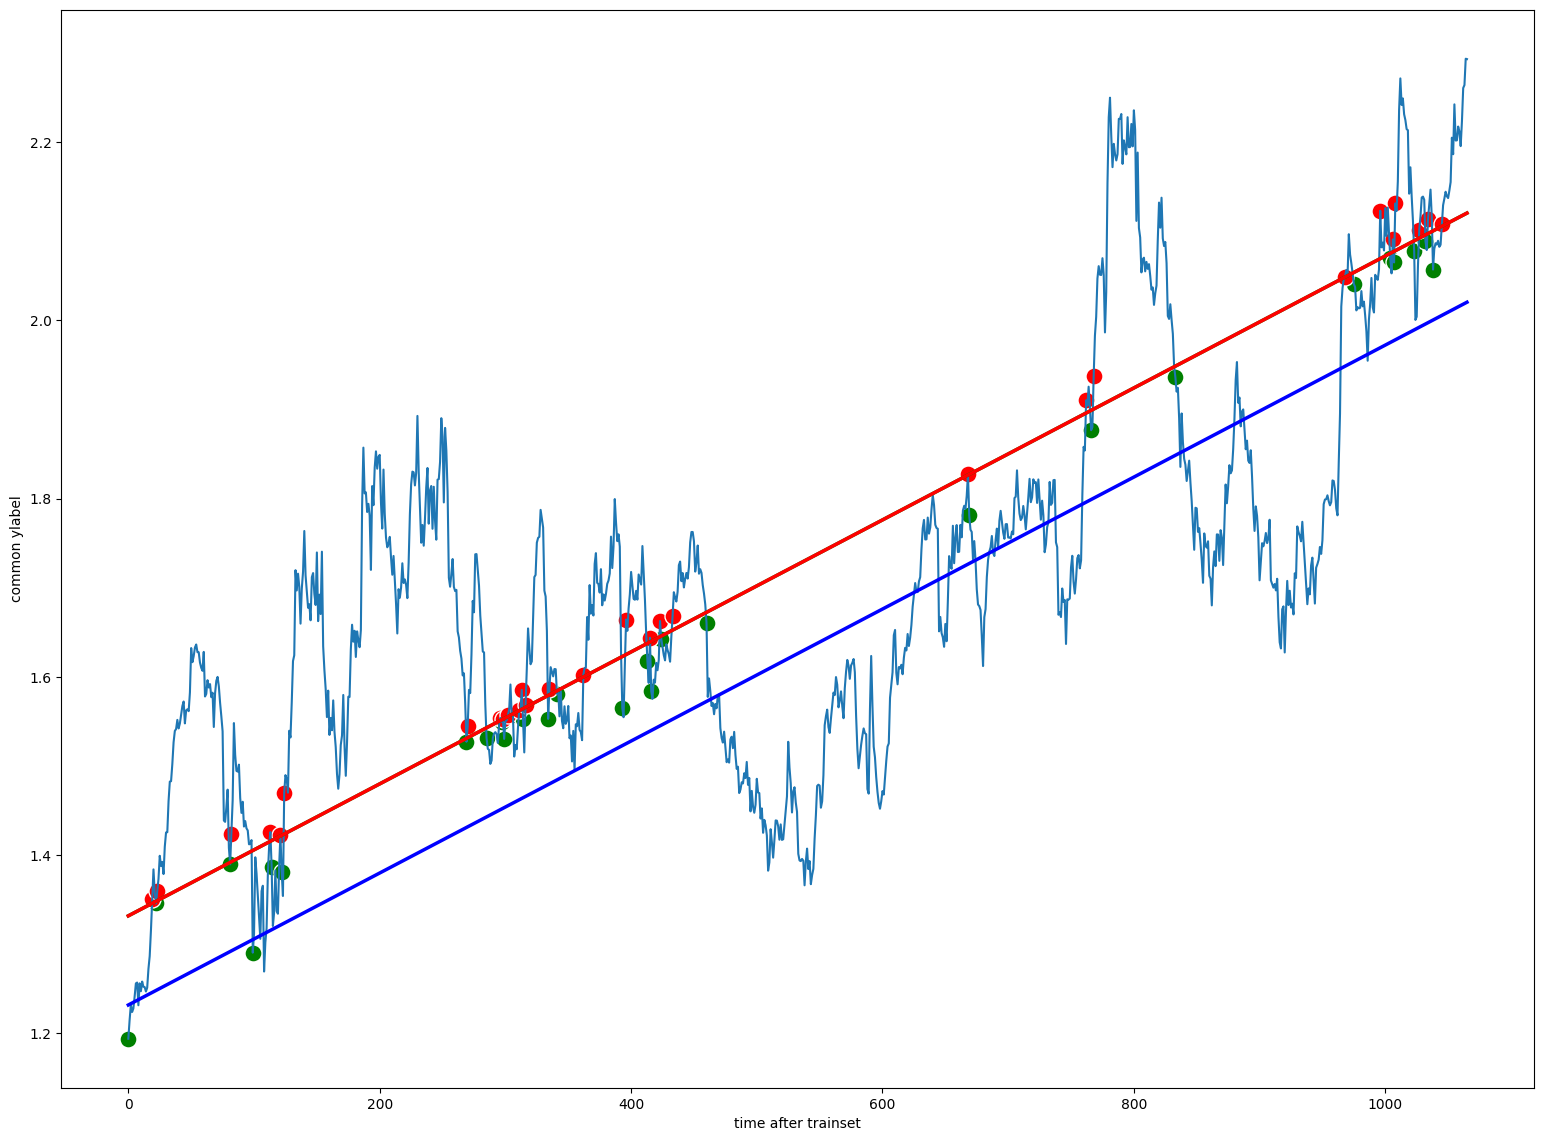

In [45]:
spreads = spreads[TRAIN_SET_END:]
print(len(spreads))

x = range(len(spreads))
spreads_df = pd.DataFrame({
    'x': x,
    'y': spreads[0]
})

plt.figure(figsize=(19, 14))

ax = sns.lineplot(data=spreads_df, x='x', y='y')

# Add long-short tresholds
y_down = [((p_x + TRAIN_SET_END) * total_slope) + total_intercept + TRADE_DOWN for p_x in x]
y_reg = [((p_x + TRAIN_SET_END) * total_slope) + total_intercept for p_x in x]
y_up = [((p_x + TRAIN_SET_END) * total_slope) + total_intercept + TRADE_UP for p_x in x]

tresholds_df = pd.DataFrame({
    'x': x,
    'y_down': y_down,
    'y_reg': y_reg,
    'y_up': y_up
})

sns.lineplot(data=tresholds_df, x='x', y='y_down', color='green', linewidth=2.5)
sns.lineplot(data=tresholds_df, x='x', y='y_reg', color='blue', linewidth=2.5)
sns.lineplot(data=tresholds_df, x='x', y='y_up', color='red', linewidth=2.5)

# Add trade entrances and exits
long_x = []
long_y = []

short_x = []
short_y = []

for x in long_entrances:
    y = spreads_df.iloc[x, 1]
    long_x.append(x)
    long_y.append(y)

for x in short_entrances:
    y = spreads_df.iloc[x, 1]
    short_x.append(x)
    short_y.append(y)

long_df = pd.DataFrame({
    'x': long_x,
    'y': long_y
})

short_df = pd.DataFrame({
    'x': short_x,
    'y': short_y
})

sns.scatterplot(data=long_df, x='x', y='y', color='green', s=150)
sns.scatterplot(data=short_df, x='x', y='y', color='red', s=150)

ax.set(xlabel='time after trainset', ylabel='common ylabel')
plt.show()

Consider a streategy that compares current $\theta$ levels against a treshold to execute a trade, we consider the OU process in its time discrete form
$$
X_{t + 1} = X_{t} + \theta \left ( \mu(t) - X_{t} \right )+ \sigma \Delta W_{n}
$$

We can take the mean-reverting force out of the time-discrete form, the force will be: $\theta \left ( \mu(t) - X_{t} \right )$

In [46]:
import ou

base_path = os.path.join(DATA_BASE, TICKER_BASE + '.pkl')
aux_path = os.path.join(DATA_BASE, TICKER_AUX + '.pkl')

base = pd.read_pickle(base_path)
aux = pd.read_pickle(aux_path)
spreads = base - aux

trainset = spreads[:TRAIN_SET_END].iloc[:, 0]
testset = spreads[TRAIN_SET_END:].iloc[:, 0]

print(len(trainset))

mean_coeff, mean_intercept, theta, sigma = ou.calibrate(trainset)

print(f'mu(t) = {mean_coeff}t + {mean_intercept}')
print(f'theta = {theta}')
print(f'sigma = {sigma}')

1450
mu(t) = 0.0007403516668030907t + 0.15829489489825466
theta = 0.020999866288636156
sigma = 0.020911893039149424


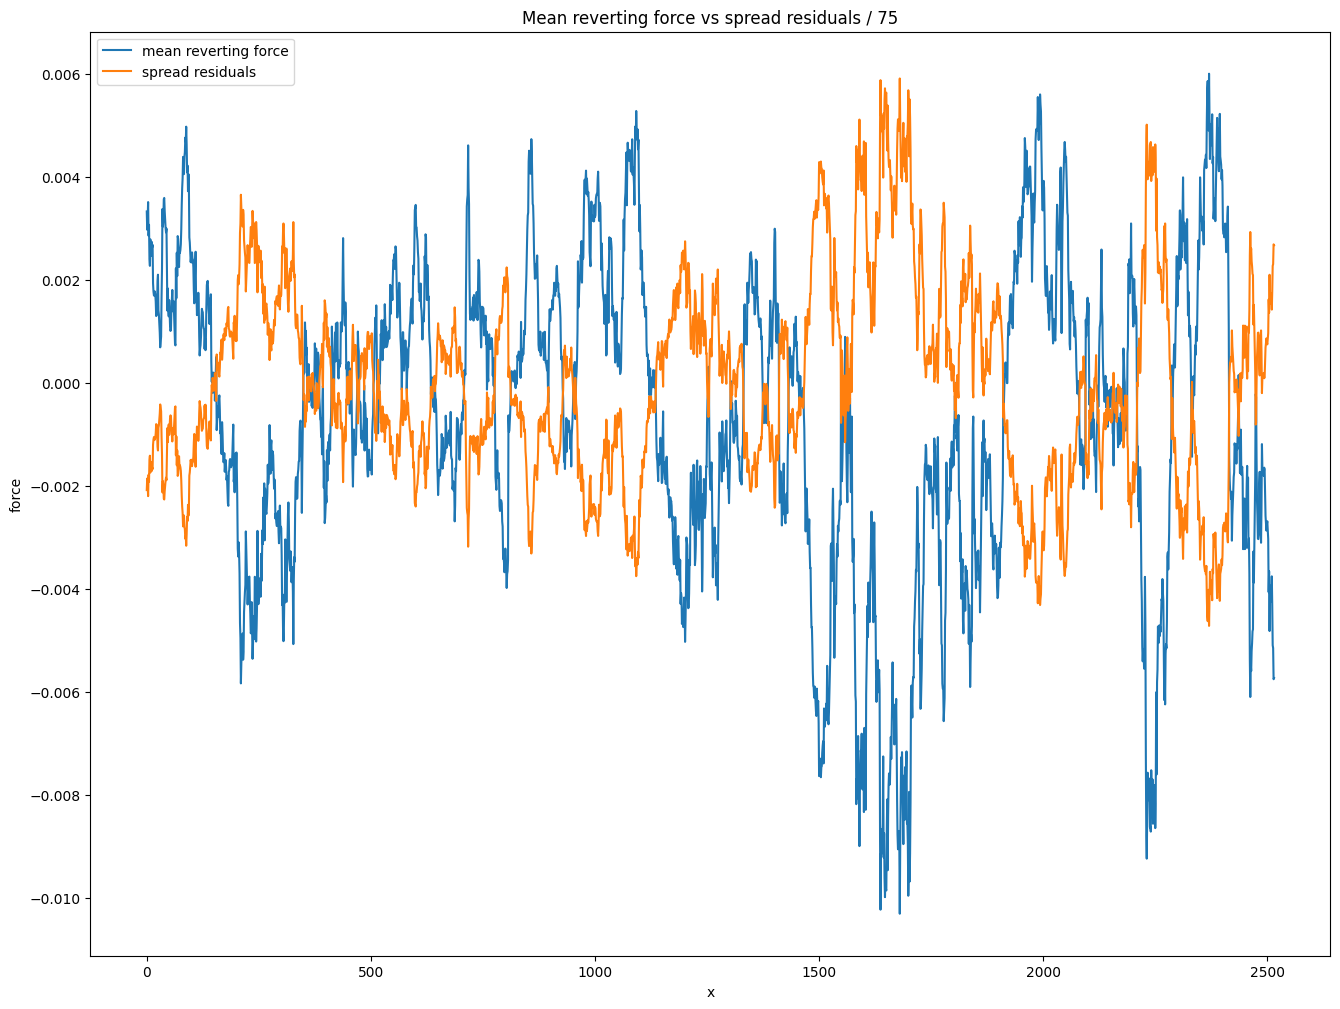

In [47]:
# graph mean reverting force in spreads

def mu(t):
    return (t * mean_coeff) + mean_intercept

forces = []
for index, row in spreads.iterrows():
    price = row[0]

    mean = mu(index)
    f = theta * (mean - price)

    forces.append(f)


# get residuals
x_param = sm.add_constant(spreads.index.to_list())
model = sm.OLS(spreads[0], x_param)
res = model.fit()

df = pd.DataFrame({
    'x': spreads.index.to_list(),
    'force': forces,
    'resid': res.resid / 75
})

plt.figure(figsize=(16, 12))
plt.title('Mean reverting force vs spread residuals / 75')
sns.lineplot(data=df, x='x', y='force', label='mean reverting force')
sns.lineplot(data=df, x='x', y='resid', label='spread residuals')
plt.show()

entering short at 1468
liquidating short at 1922
entering long at 1923
liquidating long at 2082
entering short at 2083
liquidating short at 2095
entering long at 2097
liquidating long at 2106
entering short at 2109
liquidating short at 2126
entering long at 2127
liquidating long at 2157
entering short at 2167
liquidating short at 2190
entering long at 2191
liquidating long at 2210
entering short at 2211
liquidating short at 2296
entering long at 2297
liquidating long at 2331
entering short at 2332
liquidating short at 2341
entering long at 2342
liquidating long at 2415
entering short at 2416


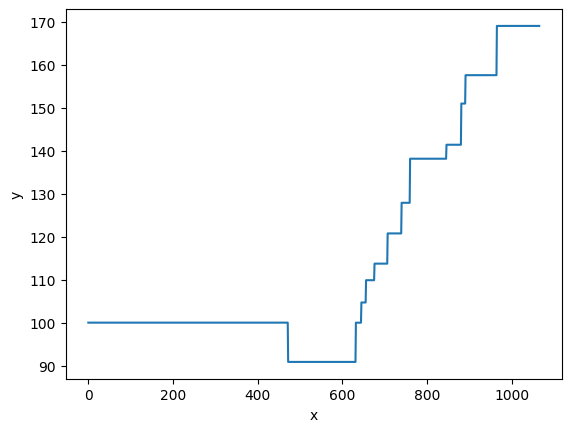

capital: 169.01155708139603


In [48]:
data = pd.DataFrame({
    'spread': testset,
    'base': base.iloc[TRAIN_SET_END:, 0],
    'aux': aux.iloc[TRAIN_SET_END:, 0]
})

class Position:
    def __init__(self, short: bool, entry: float, capital: float, entry_index: int) -> None:
        self.short = short
        self.entry = entry
        self.capital = capital
        self.entry_index = entry_index

    def liquidate(self, price: float) -> float:
        if not self.short:
            # long
            shares = self.capital / self.entry
            return shares * price
        else:
            # short
            price_delta = self.entry - price
            shares = self.capital / self.entry
            return (price_delta * shares) + self.capital


def alocate_capital_fractionally(cap, base, aux):
    total = base + aux
    num_shares = cap / total
    return num_shares * base, num_shares * aux


def backtest(signal_treshold):
    working_capital = 100

    base_position: Position = None
    aux_position: Position = None

    capital_progression = []
    long_trades = []
    short_trades = []

    for index, rows in data.iterrows():
        spread = rows['spread']
        base = rows['base']
        aux = rows['aux']

        # get mean reverting force at index
        mean = mu(index)
        force = theta * (mean - spread)

        if force > signal_treshold:
            # bet spread goes up
            # long base
            if base_position == None:
                print(f'entering long at {index}')
                base_cap, aux_cap = alocate_capital_fractionally(working_capital, base, aux)

                base_position = Position(False, base, base_cap, index)
                aux_position = Position(True, aux, aux_cap, index)

            elif base_position.short:
                # liquidate base short, aux long
                print(f'liquidating short at {index}')
                short_trades.append((base_position.entry_index, index))

                working_capital = base_position.liquidate(base)
                working_capital += aux_position.liquidate(aux)

                base_position = None
                aux_position = None

        elif -force > signal_treshold:
            # bet spread goes down
            # short base
            if base_position == None:
                print(f'entering short at {index}')
                base_cap, aux_cap = alocate_capital_fractionally(working_capital, base, aux)

                base_position = Position(True, base, base_cap, index)
                aux_position = Position(False, aux, aux_cap, index)
            elif not base_position.short:
                # liquidate base long, aux short
                print(f'liquidating long at {index}')
                long_trades.append((base_position.entry_index, index))

                working_capital = base_position.liquidate(base)
                working_capital += aux_position.liquidate(aux)

                base_position = None
                aux_position = None

        capital_progression.append(working_capital)

    return capital_progression, working_capital, long_trades, short_trades


def plot_capital_progression(cap_progress: list[float]) -> None:
    df = pd.DataFrame({
        'x': range(len(cap_progress)),
        'y': cap_progress
    })

    sns.lineplot(data=df, x='x', y='y')
    plt.show()


capital_progression, capital, long_trades, short_trades = backtest(0.001)
plot_capital_progression(capital_progression)
print(f'capital: {capital}')

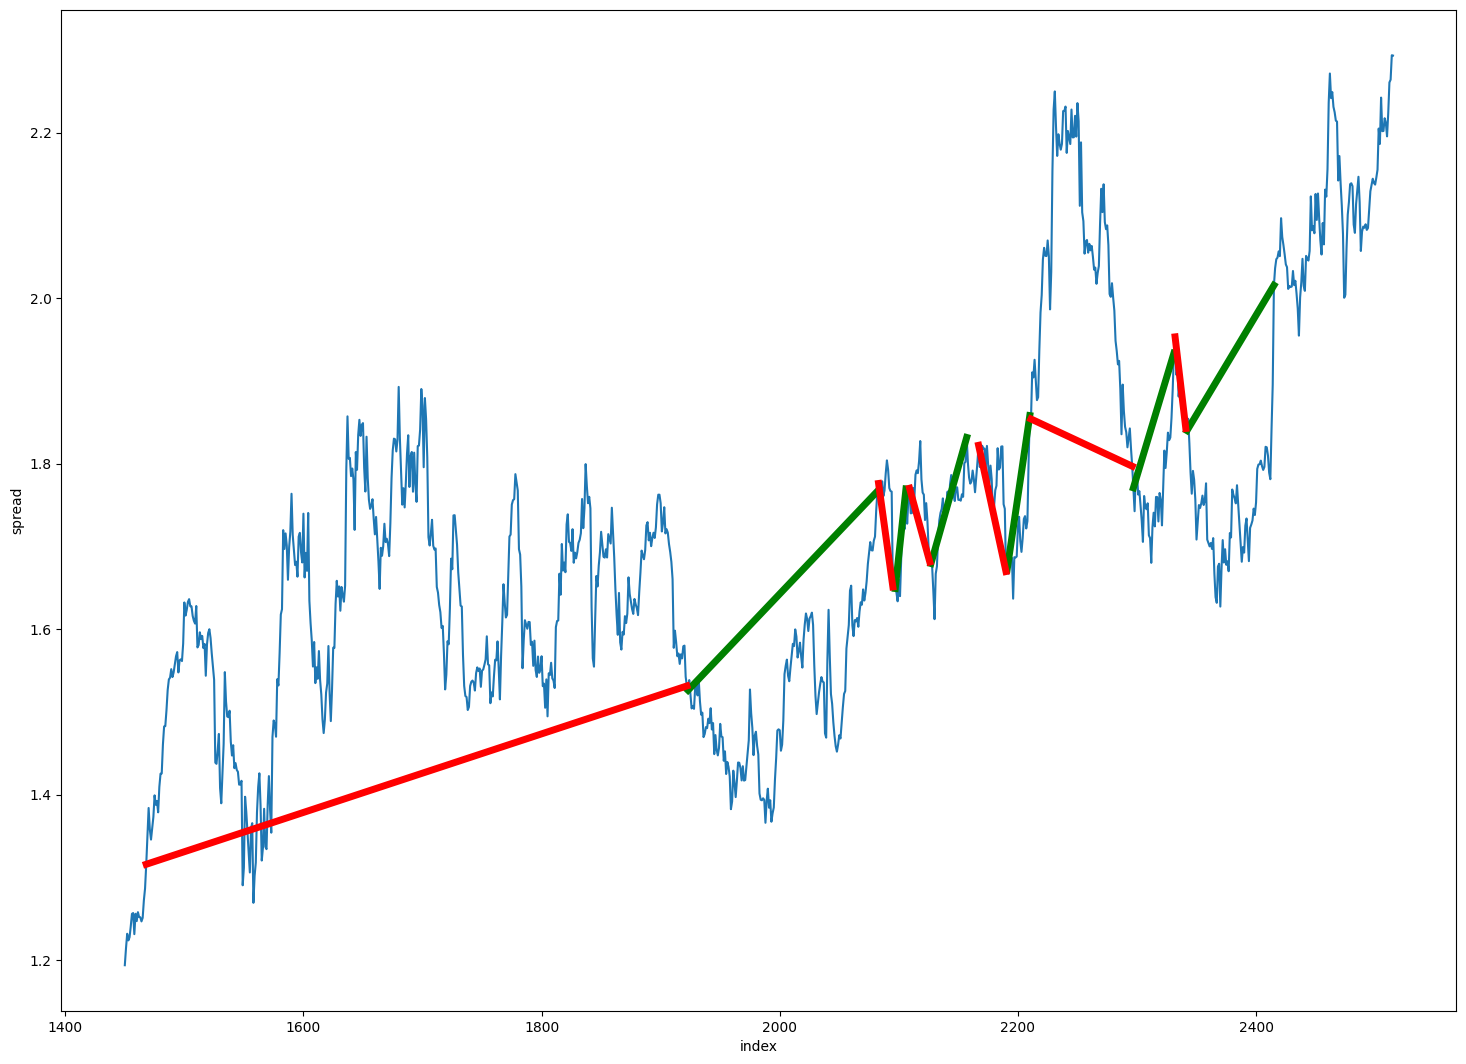

In [49]:
# show trade entrances and exits

def plot_trades(data, long_trades, short_trades):
    data['index'] = data.index

    plt.figure(figsize=(18, 13))

    sns.lineplot(data=data, x='index', y='spread')

    for (entry, exit) in long_trades:
        entry_y = data.loc[entry]['spread']
        exit_y = data.loc[exit]['spread']

        plt.plot([entry, exit], [entry_y, exit_y], linewidth=5, color='green')

    for (entry, exit) in short_trades:
        entry_y = data.loc[entry]['spread']
        exit_y = data.loc[exit]['spread']

        plt.plot([entry, exit], [entry_y, exit_y], linewidth=5, color='red')

    plt.show()


plot_trades(data, long_trades, short_trades)

## Use 150-day SMA for mean function
$$
 \mu(t) = \frac{1}{n} \sum_{i = t - n}^{t} \mathcal{X}_{i} \text{, where } |\mathcal{X}| \ge n
$$

## Smoothing using Gaussian Kernel

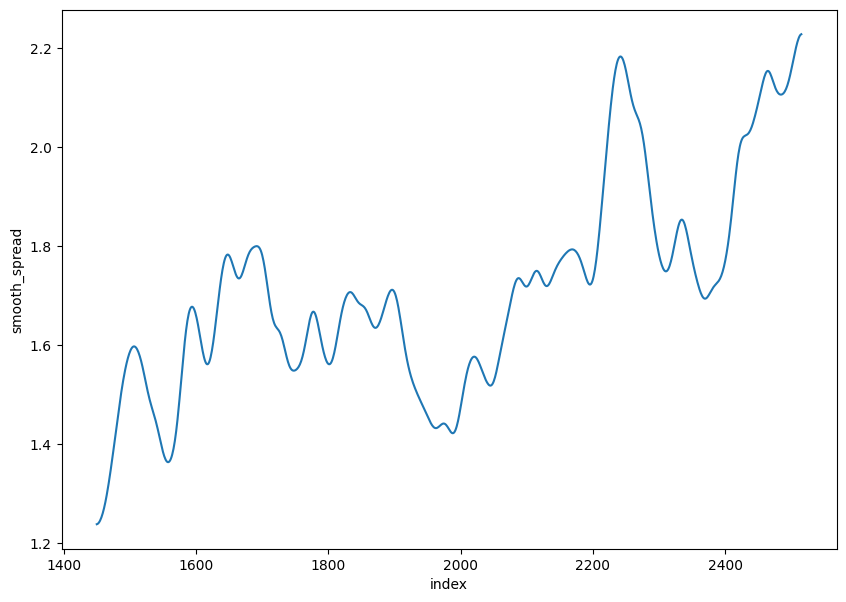

In [50]:
from scipy.ndimage import gaussian_filter1d

SIGMA = 8

data = pd.DataFrame({
    'spread': testset,
    'base': base.iloc[TRAIN_SET_END:, 0],
    'aux': aux.iloc[TRAIN_SET_END:, 0]
})


smooth = gaussian_filter1d(data['spread'].to_numpy(), sigma=SIGMA)

data['smooth_spread'] = smooth
data['index'] = data.index

plt.figure(figsize=(10, 7))
sns.lineplot(data=data, x='index', y='smooth_spread')
plt.show()


## Numerical Differentiation and supremum Detection

TypeError: 'int' object is not callable

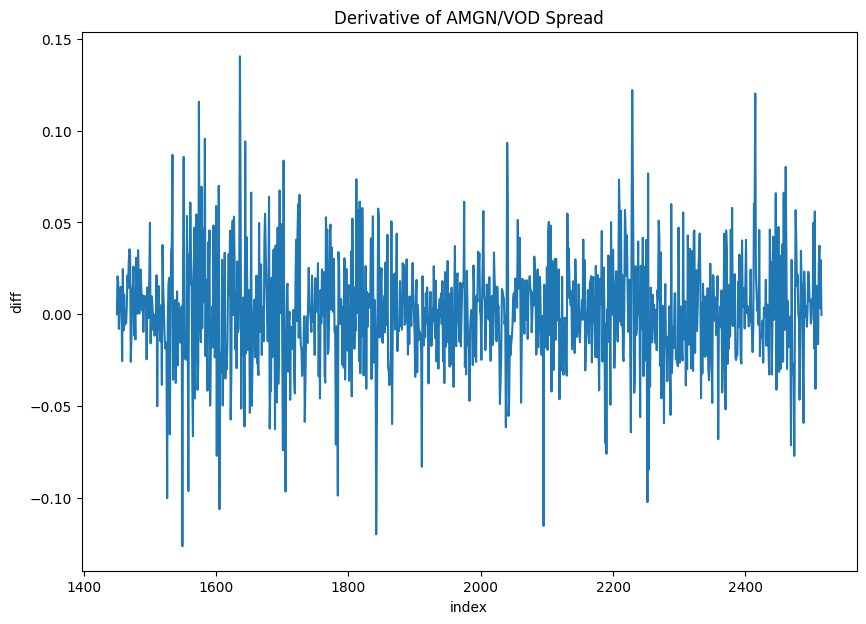

In [68]:
diff = [0]
last = 0.0

for index, value in enumerate(data['spread']):
    if index == 0:
        last = value
        continue

    difference = value - last
    last = value
    diff.append(difference)


data['diff'] = diff

plt.figure(figsize=(10, 7))
sns.lineplot(data=data, x='index', y='diff')
plt.title('Derivative of AMGN/VOD Spread')

exit()

supremum_points = []
last = 0.0
last_up = False

for index, value in enumerate(data['diff']):
    is_up = (value - last) > 0
    if index < 2:
        last = value
        last_up = is_up
        continue

    if last_up == is_up:
        continue

    # reached supremum
    supremum_points.append((index, is_up))
    last_up = is_up

supremum_x = []
supremum_y = []

for (index, _) in supremum_points:
    real_index = TRAIN_SET_END + index
    value = data['smooth_spread'][real_index]

    supremum_x.append(real_index)
    supremum_y.append(value)

supremum_df = pd.DataFrame({
    'x': supremum_x,
    'y': supremum_y
})

plt.figure(figsize=(10, 7))
sns.lineplot(data=data, x='index', y='smooth_spread')
sns.scatterplot(data=supremum_df, x='x', y='y', color='red', s=50)


plt.show()

entering short at 1506
liquidating short at 1965
entering long at 1965
liquidating long at 2088
entering short at 2088
liquidating short at 2101
entering long at 2101
liquidating long at 2115
entering short at 2115
liquidating short at 2132
entering long at 2132
liquidating long at 2167
entering short at 2167
liquidating short at 2197
entering long at 2197
liquidating long at 2242
entering short at 2242
liquidating short at 2312
entering long at 2312
liquidating long at 2465
entering short at 2465
capital: 287.51662639870415


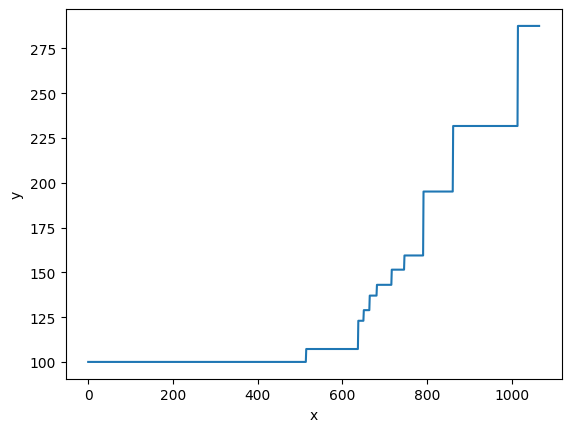

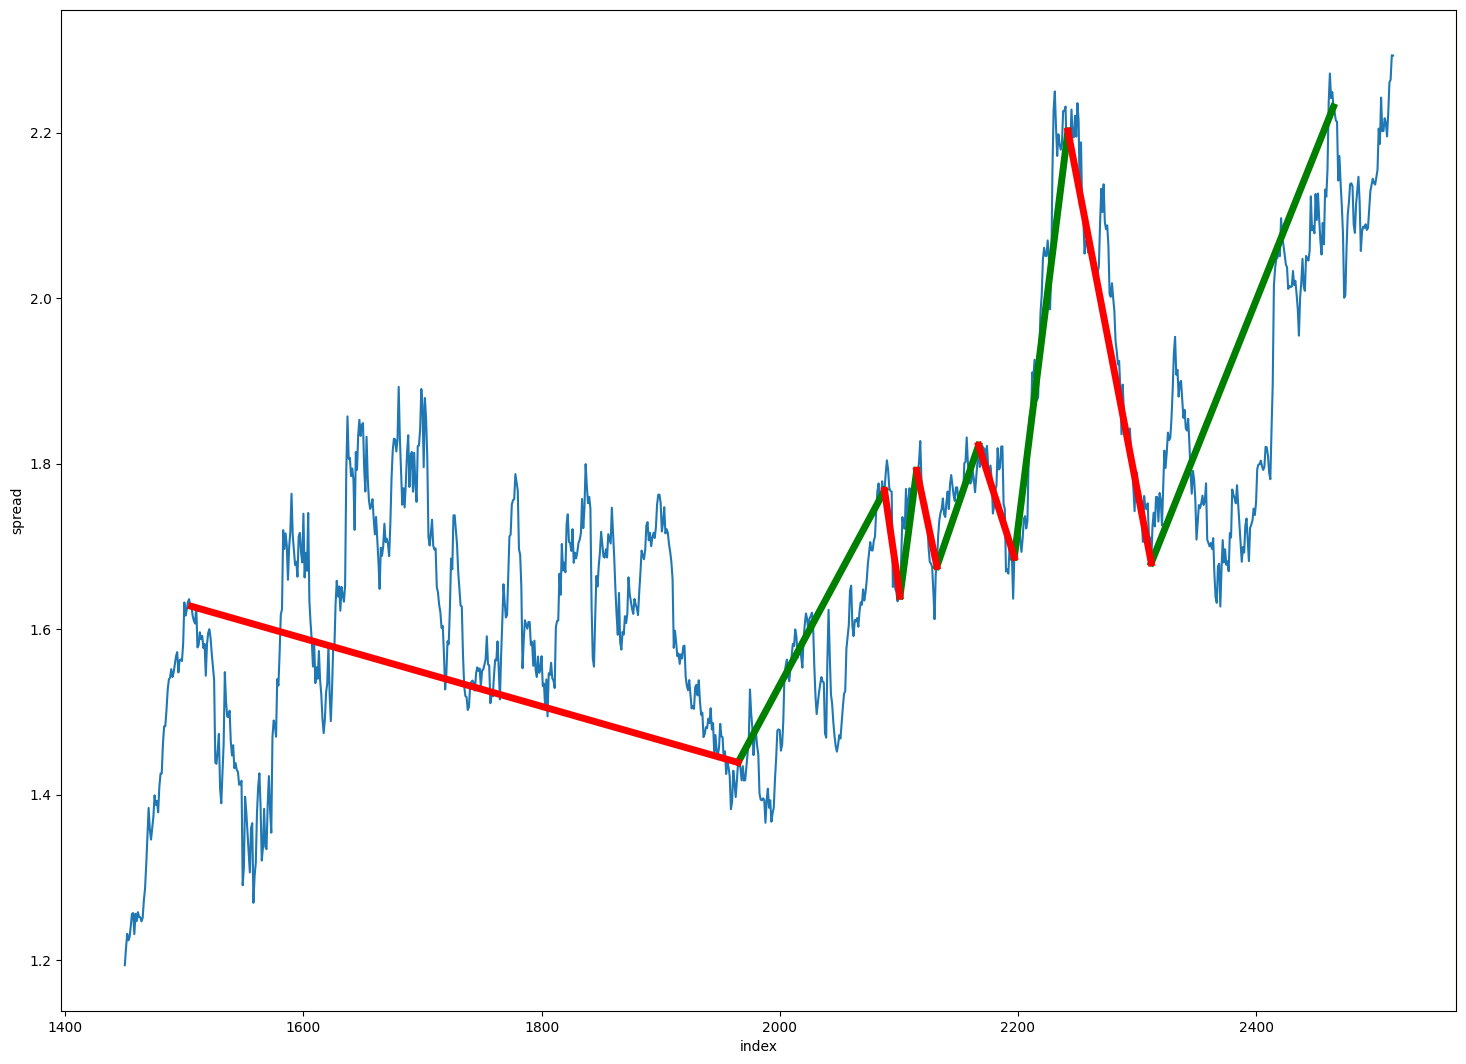

In [64]:
backtest_data = pd.DataFrame({
    'spread': testset,
    'base': base.iloc[TRAIN_SET_END:, 0],
    'aux': aux.iloc[TRAIN_SET_END:, 0]
})

def backtest(signal_treshold, data, suprema):
    working_capital = 100

    base_position: Position = None
    aux_position: Position = None

    capital_progression = []
    long_trades = []
    short_trades = []

    for index, rows in data.iterrows():
        testset_index = index - TRAIN_SET_END
        is_supremum = (testset_index in suprema) or ((index + 1) in suprema) or ((index - 1) in suprema)

        spread = rows['spread']
        base = rows['base']
        aux = rows['aux']

        # get mean reverting force at index
        mean = mu(index)
        force = theta * (mean - spread)

        if (force > signal_treshold) and is_supremum:
            if base_position != None and base_position.short:
                # liquidate base short, aux long
                print(f'liquidating short at {index}')
                short_trades.append((base_position.entry_index, index))

                working_capital = base_position.liquidate(base)
                working_capital += aux_position.liquidate(aux)

                base_position = None
                aux_position = None

            # bet spread goes up
            # long base
            if base_position == None:
                print(f'entering long at {index}')
                base_cap, aux_cap = alocate_capital_fractionally(working_capital, base, aux)

                base_position = Position(False, base, base_cap, index)
                aux_position = Position(True, aux, aux_cap, index)

        elif (-force > signal_treshold) and is_supremum:
            if base_position != None and not base_position.short:
                # liquidate base long, aux short
                print(f'liquidating long at {index}')
                long_trades.append((base_position.entry_index, index))

                working_capital = base_position.liquidate(base)
                working_capital += aux_position.liquidate(aux)

                base_position = None
                aux_position = None

            # bet spread goes down
            # short base
            if base_position == None:
                print(f'entering short at {index}')
                base_cap, aux_cap = alocate_capital_fractionally(working_capital, base, aux)

                base_position = Position(True, base, base_cap, index)
                aux_position = Position(False, aux, aux_cap, index)

        capital_progression.append(working_capital)

    return capital_progression, working_capital, long_trades, short_trades

suprema = list(map(lambda p: p[0], supremum_points))
capital_progression, capital, long_trades, short_trades = backtest(0.001, backtest_data, suprema)

print(f'capital: {capital}')
plot_capital_progression(capital_progression)

plot_trades(backtest_data, long_trades, short_trades)